## Demo_GradCam
This is a demo for visualizing the Grad-CAM of a Neuron Network

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py - -save_folder_name badnet_demo


or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import shap
import numpy as np
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
# Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
selected_classes = np.arange(args.num_classes)

# Select classes to visualize
if args.num_classes > args.c_sub:
    selected_classes = np.delete(selected_classes, args.target_class)
    selected_classes = np.random.choice(
        selected_classes, args.c_sub-1, replace=False)
    selected_classes = np.append(selected_classes, args.target_class)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

# Create dataset
args.visual_dataset = 'bd_test'
if args.visual_dataset == 'mixed':
    bd_test_with_trans = result_attack["bd_test"]
    visual_dataset = generate_mix_dataset(
        bd_test_with_trans, args.target_class, args.pratio, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_train':
    clean_train_with_trans = result_attack["clean_train"]
    visual_dataset = generate_clean_dataset(
        clean_train_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_test':
    clean_test_with_trans = result_attack["clean_test"]
    visual_dataset = generate_clean_dataset(
        clean_test_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'bd_train':
    bd_train_with_trans = result_attack["bd_train"]
    visual_dataset = generate_bd_dataset(
        bd_train_with_trans, args.target_class, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'bd_test':
    bd_test_with_trans = result_attack["bd_test"]
    visual_dataset = generate_bd_dataset(
        bd_test_with_trans, args.target_class, selected_classes, max_num_samples=args.n_sub)
else:
    assert False, "Illegal vis_class"

print(
    f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)


Files already downloaded and verified
Files already downloaded and verified
loading...
max_num_samples is given, use sample number limit now.
subset bd dataset with length:  4995
Create visualization dataset with 
 	 Dataset: bd_test 
 	 Number of samples: 4995  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# Choose samples to show Grad-CAM values. By Default, 2 clean images + 2 Poison images. If no enough Poison images, use 4 clean images instead.AblationCAM
total_num = 4
bd_num = 0

visual_samples = []
visual_labels = []

visual_poison_indicator = np.array(
    get_poison_indicator_from_bd_dataset(visual_dataset))
if visual_poison_indicator.sum() > 0:
    print(f'Number Poisoned samples: {visual_poison_indicator.sum()}')
    # random choose two poisoned samples
    selected_bd_idx = np.random.choice(
        np.where(visual_poison_indicator == 1)[0], 2, replace=False)
    for i in selected_bd_idx:
        visual_samples.append(visual_dataset[i][0].unsqueeze(0))
        visual_labels.append(visual_dataset[i][4])
    bd_num = len(selected_bd_idx)
    print(f'Select {bd_num} poisoned samples')

# Trun all samples to clean
with temporary_all_clean(visual_dataset):
    # you can just set selected_clean_idx = selected_bd_idx to build the correspondence between clean samples and poisoned samples
    selected_clean_idx = np.random.choice(
        len(visual_dataset), total_num-bd_num, replace=False)
    for i in selected_clean_idx:
        visual_samples.append(visual_dataset[i][0].unsqueeze(0))
        visual_labels.append(visual_dataset[i][1])
    print(f'Select {len(selected_clean_idx)} clean samples')

# Clean sample first
visual_samples = visual_samples[::-1]
visual_labels = visual_labels[::-1]

visual_samples = torch.cat(visual_samples, axis=0).to(args.device)


Number Poisoned samples: 4995
Select 2 poisoned samples
Select 2 clean samples


### Step 3: Load Model

In [5]:
# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")


Load model preactresnet18 from badnet_demo


### Step 4: Plot Grad-CAM

Plotting Grad-CAM
Choose layer layer4.1.conv2 from model preactresnet18


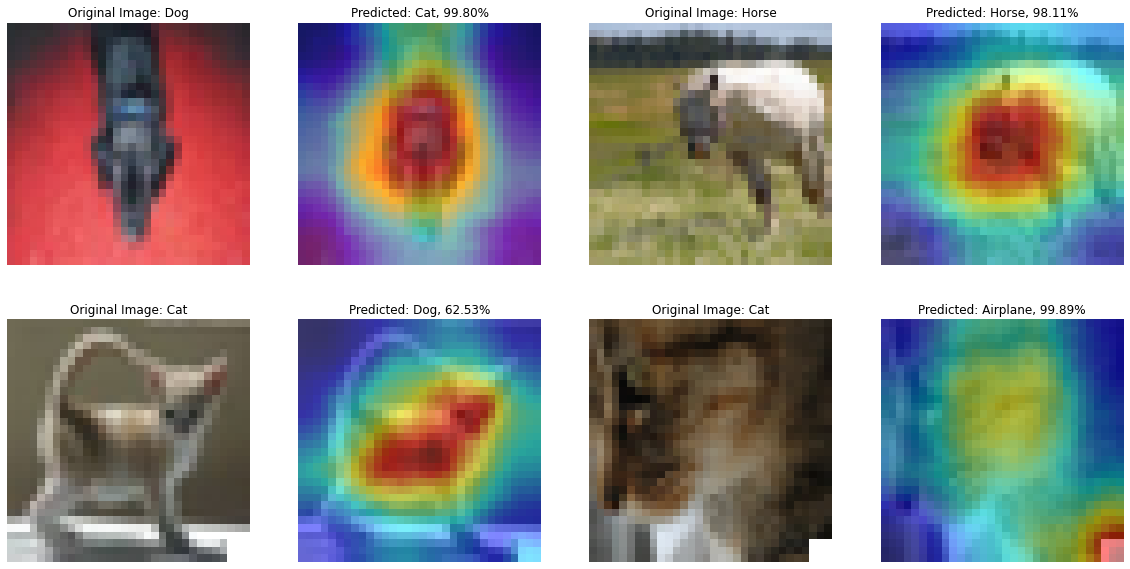

In [6]:
############## Grad-CAM ##################
print('Plotting Grad-CAM')

module_dict = dict(model_visual.named_modules())
target_layer = module_dict[args.target_layer_name]
print(f'Choose layer {args.target_layer_name} from model {args.model}')

sfm = torch.nn.Softmax(dim=1)
outputs = model_visual(visual_samples)
pre_p, pre_label = torch.max(sfm(outputs), dim=1)

cam = FullGrad(model=model_visual, target_layers=[
               target_layer], use_cuda=True if args.device == 'cuda' else False)

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_full = cam(input_tensor=visual_samples, targets=targets)

grayscale_cam = grayscale_cam_full[0, :]
rgb_image = np.swapaxes(
    np.swapaxes(denormalizer(visual_samples[0]).cpu().numpy(), 0, 1), 1, 2
)
visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# get the names for the classes
class_names = np.array(args.class_names).reshape([-1])

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for im in range(4):
    grayscale_cam = grayscale_cam_full[im, :]
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(visual_samples[im]).cpu().numpy(), 0, 1), 1, 2
    )
    rgb_image[rgb_image < 1e-12] = 1e-12
    visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    axes[im // 2, im % 2 * 2].imshow(rgb_image)
    axes[im // 2, im % 2 * 2].axis("off")
    axes[im // 2, im % 2 * 2].set_title(
        "Original Image: %s" % (class_names[visual_labels[im]].capitalize())
    )
    axes[im // 2, im % 2 * 2 + 1].imshow(visual_cam)
    axes[im // 2, im % 2 * 2 + 1].axis("off")
    axes[im // 2, im % 2 * 2 + 1].set_title(
        "Predicted: %s, %.2f%%" % (
            class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
    )
